In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import concatenate, Dense, Input, Flatten
from keras.optimizers import Adam

import sys
sys.path.append('../module/')

import gym2
from rl2.agents import eventDDPGAgent
from rl2.memory import SequentialMemory

Using TensorFlow backend.


In [2]:
# GymのPendulum環境を作成
env = gym2.make("Pendulum-v0")
clip = 10.
env.max_torque, max_torque = clip, clip
env.action_space.high, env.action_space.low = max_torque, -max_torque
# site-packages/gym/envs/classic_control/pendulum.py

# 取りうる”打ち手”のアクション数と値の定義
nb_actions = 2
ACT_ID_TO_VALUE = {0: [-1], 1: [+1]}

In [3]:
def actor_net(a_shape, s_shape):
    action_input = Input(shape=(1,)+s_shape)
    x = Flatten()(action_input)
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(3, activation="tanh")(x)
    actor = Model(inputs=action_input, outputs=x)
    return actor

def critic_net(a_shape , s_shape):
    action_input = Input(a_shape)
    observation_input = Input(shape=(1,)+s_shape)
    flattened_observation = Flatten()(observation_input)
    x = concatenate([action_input, flattened_observation])
    x = Dense(16, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    x = Dense(1, activation="linear")(x)
    critic = Model(inputs=[action_input, observation_input], outputs=x)
    return (critic, action_input)

In [4]:
def agent(a_shape, s_shape):
    actor = actor_net(a_shape, s_shape)
    critic,  critic_action_input = critic_net(a_shape, s_shape)
    memory = SequentialMemory(limit = 50000, window_length = 1)
    agent = eventDDPGAgent(
        a_shape[0],
        actor,
        critic,
        critic_action_input,
        memory,
        clip_com = 0.01
    )
    return agent

In [19]:
#event-base learning
l = 0.
step = 10000
time_mode = True
a =  agent((3,), env.observation_space.shape)
a.compile(Adam(lr=0.001, clipnorm=1.), metrics=["mae"])
#a.load_weights('../learned_models_vol2/0.5standup-agent.h5')
a.fit(env, lam=l, nb_steps=step, visualize=1, verbose=1, nb_max_episode_steps=200, loss_graph=0, time_mode=time_mode)

Training for 10000 steps ...
Interval 1 (0 steps performed)
 3728/10000 [==========>...................] - ETA: 2:37 - reward: -7.5921done, took 93.583 seconds


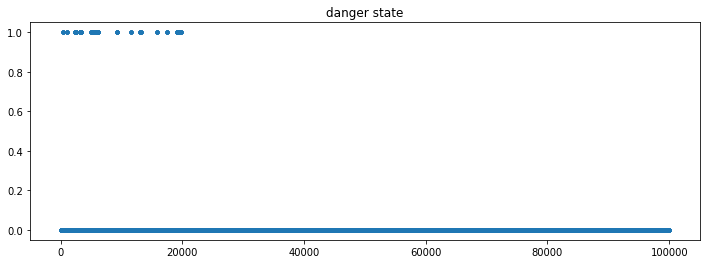

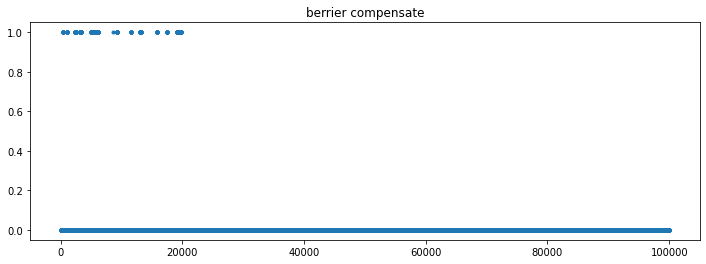

In [17]:
plt.figure(figsize=(12,4))
plt.title('danger state')
plt.scatter(range(step), a.cbf_log[:,0], marker='.')
plt.show()
plt.figure(figsize=(12,4))
plt.title('berrier compensate')
plt.scatter(range(step), a.cbf_log[:,1], marker='.')
plt.show()

In [10]:
a.test(env, lam=l, visualize=False, nb_max_episode_steps=200, action_view=1, time_mode=time_mode)

Testing for 1 episodes ...
step =  1 , output of actor network =  [ 9.554423   1.        -0.9999972]
step =  2 , output of actor network =  [-9.999425   1.        -1.0000001]
step =  3 , output of actor network =  [-8.734877   1.        -0.9999988]
step =  4 , output of actor network =  [ 9.999859    1.         -0.99997085]
step =  5 , output of actor network =  [-9.854141   1.        -0.9999993]
step =  6 , output of actor network =  [ 9.997915   1.        -0.9999874]
step =  7 , output of actor network =  [-9.990124   1.        -0.9999997]
step =  8 , output of actor network =  [ 9.897946  1.       -0.999996]
step =  9 , output of actor network =  [-9.999727   1.        -0.9999999]
step =  10 , output of actor network =  [-2.0072653   1.         -0.99999917]
step =  11 , output of actor network =  [ 9.999996    1.         -0.99992675]
step =  12 , output of actor network =  [ 0.6292271   1.         -0.99999917]
step =  13 , output of actor network =  [-9.972254    1.         -0.99999

step =  113 , output of actor network =  [-9.880214    1.         -0.99999964]
step =  114 , output of actor network =  [ 9.999562    1.         -0.99998456]
step =  115 , output of actor network =  [-9.975251    1.         -0.99999964]
step =  116 , output of actor network =  [ 9.993513   1.        -0.9999925]
step =  117 , output of actor network =  [-9.997655   1.        -0.9999999]
step =  118 , output of actor network =  [ 9.655939   1.        -0.9999975]
step =  119 , output of actor network =  [-9.999929   1.        -0.9999999]
step =  120 , output of actor network =  [-7.276945   1.        -0.9999995]
step =  121 , output of actor network =  [ 9.999973    1.         -0.99995846]
step =  122 , output of actor network =  [-6.527771   1.        -0.9999994]
step =  123 , output of actor network =  [ 9.999987    1.         -0.99995047]
step =  124 , output of actor network =  [-6.5159373  1.        -0.9999994]
step =  125 , output of actor network =  [ 9.999992    1.         -0.9999

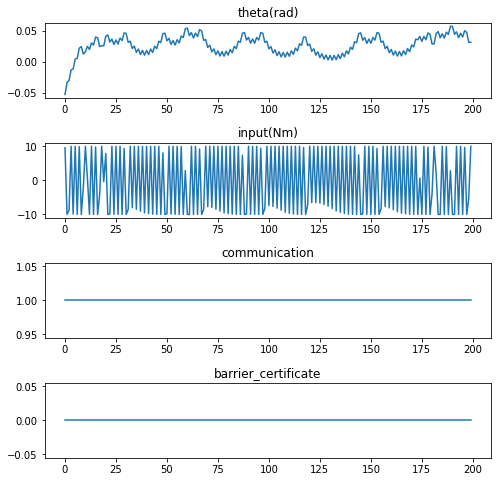

In [11]:
titles = ['theta(rad)', 'input(Nm)', 'communication', 'barrier_certificate'] 
history = a.data_log[0]
x_axis = range(200)
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
for i in range(4):
    data = history[:,i]
    plt.subplot(4,1,i+1)
    plt.title(titles[i])
    plt.plot(x_axis, data)
plt.show()

In [9]:
print(np.unique(history[:,1]))

[-2.          0.44251469  2.        ]


In [12]:
print(env.max_torque)
print(env.action_space)

10.0
Box(1,)
